# Vignette

This vignette extends the [vignette for the R-version of tximport](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html). If you are unfamiliar with `tximport` or curious about the motivation behind it, please check it out.

## Creating your transcript to gene map

Here, we will show you how to generate a transcript_gene_map data frame based on the Ensembl reference or a gene transfer format file.

### Build it from Ensembl

This example requires `pybiomart`, an optional dependency of `pytximport`.

In [1]:
from pytximport.utils import create_transcript_to_gene_map

transcript_gene_map_human = create_transcript_to_gene_map("human", field="external_gene_name")
transcript_gene_map_human.head(5)

,transcript_id,gene_id
0,ENST00000387314,MT-TF
1,ENST00000389680,MT-RNR1
2,ENST00000387342,MT-TV
3,ENST00000387347,MT-RNR2
4,ENST00000386347,MT-TL1


In [2]:
transcript_gene_map_mouse = create_transcript_to_gene_map("mouse", field="external_gene_name")
transcript_gene_map_mouse.head(5)

,transcript_id,gene_id
0,ENSMUST00000082387,mt-Tf
1,ENSMUST00000082388,mt-Rnr1
2,ENSMUST00000082389,mt-Tv
3,ENSMUST00000082390,mt-Rnr2
4,ENSMUST00000082391,mt-Tl1


### Use a gene transfer format file

If you already have an annotation file in .gtf format (e.g. from the GENCODE or Ensembl references), you can use the `create_transcript_to_gene_map_from_gtf_annotation` function contained in `pytximport.utils` to generate a transcript to gene map.

## Importing transcript quantification files

You can easily import quantification files from tools like `salmon` with `pytximport`.

In [3]:
import numpy as np
import pandas as pd
from pytximport import tximport

In [4]:
txi = tximport(
    ["../../test/data/salmon/multiple/Sample_1.sf", "../../test/data/salmon/multiple/Sample_2.sf"],
    "salmon",
    transcript_gene_map_mouse,
    output_type="xarray",  # or "anndata"
)
txi

Reading quantification files: 2it [00:00, 250.25it/s]


<xarray.Dataset> Size: 50kB
Dimensions:    (gene_id: 494, file: 2, file_path: 2)
Coordinates:
  * gene_id    (gene_id) <U13 26kB 'Gm11581' 'Casp2' ... 'Ankrd28' 'Prkag1'
  * file_path  (file_path) <U43 344B '../../test/data/salmon/multiple/Sample_...
Dimensions without coordinates: file
Data variables:
    abundance  (gene_id, file) float64 8kB 0.08291 0.0 0.09854 ... 0.4618 0.0
    counts     (gene_id, file) float64 8kB 1.001 0.0 1.042 ... 2.0 6.184 0.0
    length     (gene_id, file) float64 8kB 509.1 509.1 445.8 ... 564.6 564.6

## Exporting transcript-level count estimates

You can also export the transformed transcript counts directly for transcript-level analysis.

In [5]:
txi = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    counts_from_abundance="scaled_tpm",  # provide a transcript_gene_map and use "dtu_scaled_tpm"
    return_transcript_data=True,
)
txi

Reading quantification files: 1it [00:00, 346.26it/s]


AnnData object with n_obs × n_vars = 1 × 14
    obsm: 'length', 'abundance'

Note that the example above works without a transcript to gene map. If you want to use the transcript names instead of the transcript ides, you can optionally use the `replace_transcript_ids_with_names` function together with a transcript id to transcript name map.
We can use the `create_transcript_to_gene_map` function to create a map between transcript ids and transcript names, too.

In [6]:
from pytximport.utils import replace_transcript_ids_with_names

In [7]:
transcript_name_map_human = create_transcript_to_gene_map("human", field="external_transcript_name")
transcript_name_map_human.head(5)

,transcript_id,transcript_name
0,ENST00000387314,MT-TF-201
1,ENST00000389680,MT-RNR1-201
2,ENST00000387342,MT-TV-201
3,ENST00000387347,MT-RNR2-201
4,ENST00000386347,MT-TL1-201


In [8]:
txi = replace_transcript_ids_with_names(txi, transcript_name_map_human)
pd.DataFrame(txi.X.T, index=txi.var.index, columns=txi.obs.index).sort_values(
    by=txi.obs.index[0],
    ascending=False,
).head(5)

,../../test/data/salmon/quant.sf
HOXC8-201,4486.940412
UGT3A2-201,1307.314695
HOXC9-201,886.909534
HOXC4-202,749.069369
HOXC12-201,544.817685


The same data summarized to genes:

In [9]:
txi = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    transcript_gene_map_human,
    counts_from_abundance="scaled_tpm",
    output_type="xarray",
    return_transcript_data=False,
)
pd.DataFrame(txi["counts"], index=txi.coords["gene_id"], columns=txi.coords["file_path"]).sort_values(
    by=txi.coords["file_path"].data[0],
    ascending=False,
).head(5)

Reading quantification files: 1it [00:00, 107.84it/s]


,../../test/data/salmon/quant.sf
HOXC8,4486.940412
UGT3A2,1506.597257
HOXC4,1152.964133
HOXC9,886.909534
HOXC12,544.817685


Note that the top transcript corresponds to the top expressed gene in this case.

## Exporting AnnData files

`pytximport` integrates well with other packages from the `scverse` through its `AnnData` export option.

In [10]:
txi_ad = tximport(
    ["../../test/data/salmon/quant.sf"],
    "salmon",
    transcript_gene_map_human,
    output_type="anndata",
    # the output can optionally be saved to a file by uncommenting the following lines
    # output_format="h5ad",
    # save_path="txi_ad.h5ad",
)
txi_ad

Reading quantification files: 1it [00:00, 379.64it/s]


AnnData object with n_obs × n_vars = 1 × 10
    obsm: 'length', 'abundance'

## Use from the command line

You can run `pytximport` from the command line, too. Available options can be viewed via the `pytximport --help` command.

In [11]:
!pytximport -i ../../test/data/salmon/quant.sf -t "salmon" -m ../../test/data/gencode.v46.metadata.HGNC.tsv --output_type "anndata" --output_format "h5ad" --save_path_overwrite -o ../../test/data/salmon/quant.h5ad

Usage: pytximport [OPTIONS]
Try 'pytximport --help' for help.

Error: No such option: --save_path_overwrite (Possible options: --save-path-override, --save_path, --save_path_override)


## Inferential replicates

`pytximport` can handle bootstraping replicates provided by `salmon` and `kallisto`. When `inferential_replicate_transformer` is set, the provided function is used to recalculate the counts and abundances for each sample based on the bootstraps.

In [12]:
result = tximport(
    [
        "../../test/data/fabry_disease/SRR16504309_wt/",
        "../../test/data/fabry_disease/SRR16504310_wt/",
        "../../test/data/fabry_disease/SRR16504311_ko/",
        "../../test/data/fabry_disease/SRR16504312_ko/",
    ],
    "salmon",
    transcript_gene_map_human,
    inferential_replicates=True,
    inferential_replicate_variance=True,  # whether to calculate the variance of the inferential replicates
    inferential_replicate_transformer=lambda x: np.median(x, axis=1),
    counts_from_abundance="length_scaled_tpm",
)
result

Reading quantification files: 4it [00:01,  2.16it/s]


AnnData object with n_obs × n_vars = 4 × 40768
    uns: 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

## Downstream analysis with PyDESeq2

The output from `pytximport` can easily be used for downstream analysis with `PyDESeq2`. For more information on `PyDESeq2`, please consult its [documentation](https://pydeseq2.readthedocs.io/en/latest/).

In [13]:
%pip install pydeseq2 decoupler adjustText omnipath tqdm seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [14]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc

Load the .csv file generated by `pytximport` via the `save_path` argument or create it directly from the output of `pytximport`. In this case, we are working with the salmon quantification files from a public bulk RNA sequencing dataset: [Podocyte injury in Fabry nephropathy](https://www.ebi.ac.uk/ena/browser/view/PRJNA773084)

Round count estimates (required by PyDESeq2) and add the corresponding metadata.

In [15]:
result.X = result.X.round().astype(int)
result.obs["condition"] = ["Control", "Control", "Disease", "Disease"]
result

AnnData object with n_obs × n_vars = 4 × 40768
    obs: 'condition'
    uns: 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

Filter genes with low counts out.

In [16]:
result = result[:, result.X.max(axis=0) > 10].copy()
result

AnnData object with n_obs × n_vars = 4 × 14714
    obs: 'condition'
    uns: 'inferential_replicates'
    obsm: 'length', 'abundance', 'variance'

Now perform your `PyDESeq2` analysis.

In [17]:
dds = DeseqDataSet(
    adata=result,
    design_factors="condition",
    refit_cooks=True,
    inference=DefaultInference(n_cpus=8),
    quiet=True,
)

In [18]:
dds.deseq2()

/Users/au734063/Documents/code/pytximport-publish/pytximport/.venv/lib/python3.10/site-packages/pydeseq2/dds.py:490: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


In [19]:
stat_result = DeseqStats(dds, contrast=("condition", "Disease", "Control"))

In [20]:
%%capture
stat_result.summary()

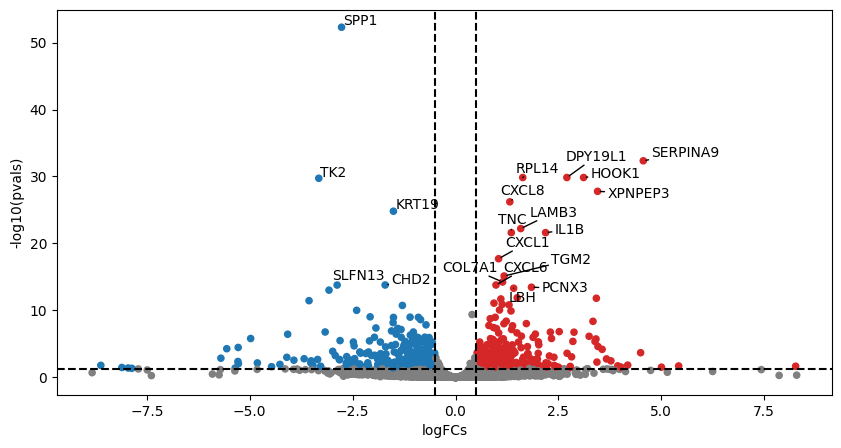

In [21]:
dc.plot_volcano_df(stat_result.results_df, x="log2FoldChange", y="padj", top=20, figsize=(10, 5))

/Users/au734063/Documents/code/pytximport-publish/pytximport/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running ulm on mat with 1 samples and 14714 targets for 660 sources.


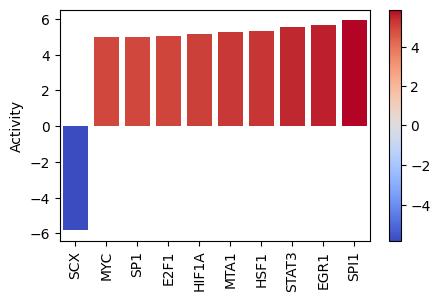

In [22]:
collectri = dc.get_collectri(organism="human", split_complexes=False)
mat = stat_result.results_df[["stat"]].T.rename(index={"stat": "disease.vs.control"})
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
dc.plot_barplot(acts=tf_acts, contrast="disease.vs.control", top=10, vertical=False, figsize=(5, 3))

We can also evaluate known pathways.

In [23]:
progeny = dc.get_progeny(top=500)
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, min_n=5)

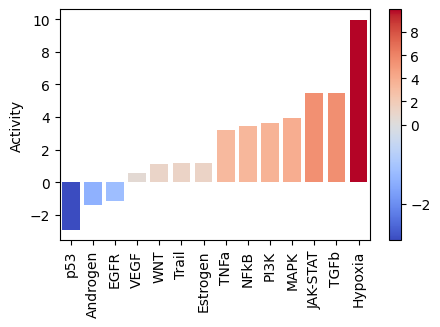

In [24]:
dc.plot_barplot(acts=pathway_acts, contrast="disease.vs.control", top=40, vertical=False, figsize=(5, 3))

Please refer to the `PyDESeq2` and the `decoupler` documentation for additional analyses.